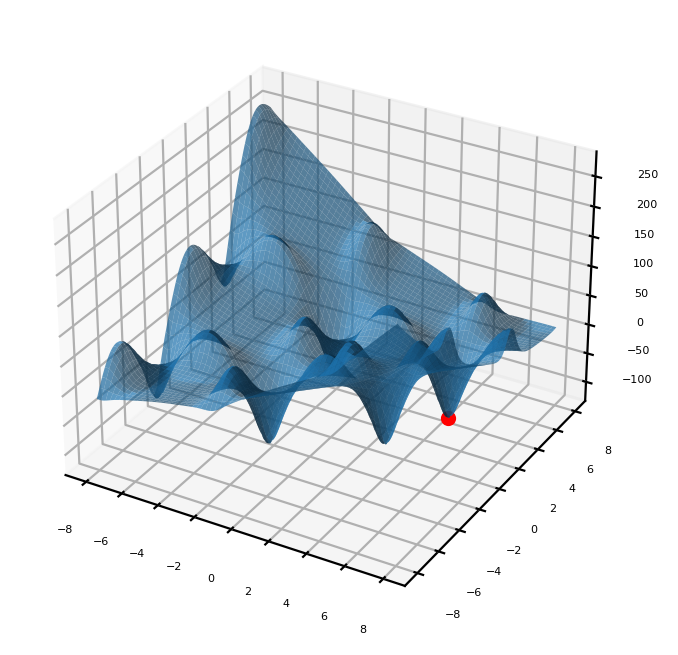

In [1]:
import numpy as np
import matplotlib.pyplot as plot


radius = 8                                  # working plane radius
global_epsilon = 0.000000001                # argument increment for derivative
centre = (global_epsilon, global_epsilon)   # centre of the working circle
arr_shape = 100                             # number of points processed / 360
step = radius / arr_shape                   # step between two points


def differentiable_function(x, y):
    return np.sin(x) * np.exp((1 - np.cos(y)) ** 2) + \
           np.cos(y) * np.exp((1 - np.sin(x)) ** 2) + (x - y) ** 2


def rotate_vector(length, a):
    return length * np.cos(a), length * np.sin(a)


def derivative_x(epsilon, arg):
    return (differentiable_function(global_epsilon + epsilon, arg) -
            differentiable_function(epsilon, arg)) / global_epsilon


def derivative_y(epsilon, arg):
    return (differentiable_function(arg, epsilon + global_epsilon) -
            differentiable_function(arg, epsilon)) / global_epsilon


def calculate_flip_points():
    flip_points = np.array([0, 0])
    points = np.zeros((360, arr_shape), dtype=bool)
    cx, cy = centre

    for i in range(arr_shape):
        for alpha in range(360):
            x, y = rotate_vector(step, alpha)
            x = x * i + cx
            y = y * i + cy
            points[alpha][i] = derivative_x(x, y) + derivative_y(y, x) > 0
            if not points[alpha][i - 1] and points[alpha][i]:
                flip_points = np.vstack((flip_points, np.array([alpha, i - 1])))

    return flip_points


def pick_estimates(positions):
    vx, vy = rotate_vector(step, positions[1][0])
    cx, cy = centre
    best_x, best_y = cx + vx * positions[1][1], cy + vy * positions[1][1]

    for index in range(2, len(positions)):
        vx, vy = rotate_vector(step, positions[index][0])
        x, y = cx + vx * positions[index][1], cy + vy * positions[index][1]
        if differentiable_function(best_x, best_y) > differentiable_function(x, y):
            best_x = x
            best_y = y

    for index in range(360):
        vx, vy = rotate_vector(step, index)
        x, y = cx + vx * (arr_shape - 1), cy + vy * (arr_shape - 1)
        if differentiable_function(best_x, best_y) > differentiable_function(x, y):
            best_x = x
            best_y = y

    return best_x, best_y


def gradient_descent(best_estimates, is_x):
    derivative = derivative_x if is_x else derivative_y
    best_x, best_y = best_estimates
    descent_step = step
    value = derivative(best_y, best_x)

    while abs(value) > global_epsilon:
        descent_step *= 0.95
        best_y = best_y - descent_step \
            if derivative(best_y, best_x) > 0 else best_y + descent_step
        value = derivative(best_y, best_x)

    return best_y, best_x


def find_minimum():
    return gradient_descent(gradient_descent(pick_estimates(calculate_flip_points()), False), True)


def get_grid(grid_step):
    samples = np.arange(-radius, radius, grid_step)
    x, y = np.meshgrid(samples, samples)
    return x, y, differentiable_function(x, y)


def draw_chart(point, grid):
    point_x, point_y, point_z = point
    grid_x, grid_y, grid_z = grid
    plot.rcParams.update({
        'figure.figsize': (4, 4),
        'figure.dpi': 200,
        'xtick.labelsize': 4,
        'ytick.labelsize': 4
    })
    ax = plot.figure().add_subplot(111, projection='3d')
    ax.scatter(point_x, point_y, point_z, color='red')
    ax.plot_surface(grid_x, grid_y, grid_z, rstride=5, cstride=5, alpha=0.7)
    plot.show()


if __name__ == '__main__':
    min_x, min_y = find_minimum()
    minimum = (min_x, min_y, differentiable_function(min_x, min_y))
    draw_chart(minimum, get_grid(0.05))

